In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pillow
!pip install numpy

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, LeakyReLU, Input, Dropout, Activation
from tensorflow.keras.models import Model

In [ ]:
class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(name='scale',
                                     shape=input_shape[-1:],
                                     initializer=tf.random_normal_initializer(1., 0.02),
                                     trainable=True)
        self.offset = self.add_weight(name='offset',
                                      shape=input_shape[-1:],
                                      initializer='zeros',
                                      trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

    def get_config(self):
        config = super(InstanceNormalization, self).get_config()
        config.update({"epsilon": self.epsilon})
        return config

In [ ]:
from tensorflow.keras.models import load_model

# Ensure that the InstanceNormalization class is defined as shown above

# Loading the model with the custom object
generator_g = load_model('/content/generator_g-2.h5', custom_objects={'InstanceNormalization': InstanceNormalization}, compile=False)
generator_f = load_model('/content/generator_f-2.h5', custom_objects={'InstanceNormalization': InstanceNormalization}, compile=False)

In [ ]:
import re

In [ ]:
def sort_key(filename):
    """ Extract leading numbers for sorting filenames numerically if present. """
    numbers = re.match(r'(\d+)', filename)
    return int(numbers.group(0)) if numbers else float('inf'), filename

def load_images_from_folder(folder):
    images = []
    # Sort files by leading numbers, then alphabetically
    sorted_filenames = sorted(os.listdir(folder), key=sort_key)
    for filename in sorted_filenames:
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, color_mode='grayscale', target_size=(256, 256))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)  # Shape (1, 256, 256, 1)
        images.append(img)
        print(f'Loaded {filename} with shape {img.shape}')
    return np.vstack(images)  # Stack images for batch processing

ct_test_images = load_images_from_folder('/content/drive/MyDrive/z4wc364g79-1/JUH_MR-CT_splits/CT/test/images')
mri_test_images = load_images_from_folder('/content/drive/MyDrive/z4wc364g79-1/JUH_MR-CT_splits/MR/test/images')


Loaded 1_CT_s1_aug_18_cropped.png with shape (1, 256, 256, 1)
Loaded 1_CT_s2_aug_12_cropped.png with shape (1, 256, 256, 1)
Loaded 1_CT_s2_aug_3_cropped.png with shape (1, 256, 256, 1)
Loaded 1_CT_s2_aug_8_cropped.png with shape (1, 256, 256, 1)
Loaded 1_CT_s2_aug_9_cropped.png with shape (1, 256, 256, 1)
Loaded 1_CT_s3_aug_17_cropped.png with shape (1, 256, 256, 1)
Loaded 1_CT_s4_aug_0_cropped.png with shape (1, 256, 256, 1)
Loaded 1_CT_s5_aug_11_cropped.png with shape (1, 256, 256, 1)
Loaded 2_CT_s1_aug_1_cropped.png with shape (1, 256, 256, 1)
Loaded 2_CT_s2_aug_10_cropped.png with shape (1, 256, 256, 1)
Loaded 2_CT_s2_aug_2_cropped.png with shape (1, 256, 256, 1)
Loaded 2_CT_s2_aug_4_cropped.png with shape (1, 256, 256, 1)
Loaded 2_CT_s2_aug_9_cropped.png with shape (1, 256, 256, 1)
Loaded 2_CT_s3_aug_8_cropped.png with shape (1, 256, 256, 1)
Loaded 2_CT_s4_aug_18_cropped.png with shape (1, 256, 256, 1)
Loaded 2_CT_s4_aug_7_cropped.png with shape (1, 256, 256, 1)
Loaded 3_CT_s1_aug

In [ ]:
# MRI to CT translation
translated_mri_to_ct = generator_g.predict(mri_test_images)

# CT to MRI translation
translated_ct_to_mri = generator_f.predict(ct_test_images)

6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


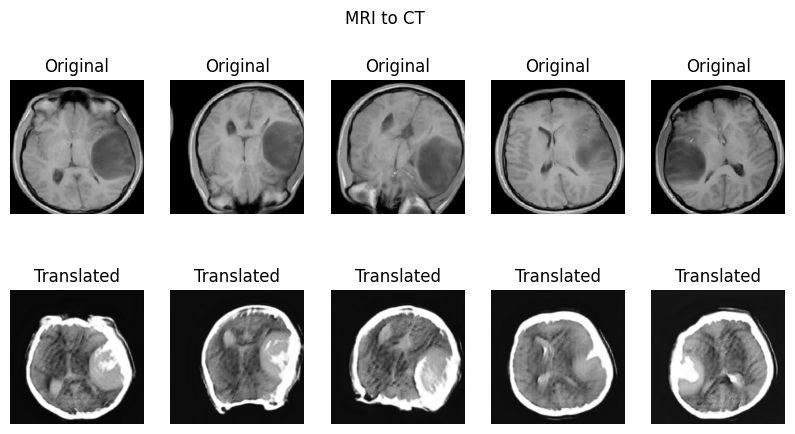

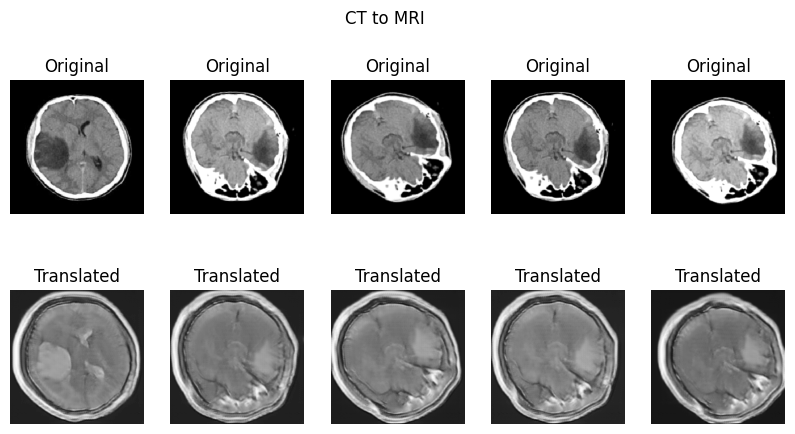

In [ ]:
def display_images(original, translated, title='Original and Translated'):
    plt.figure(figsize=(10, 5))
    for i in range(min(5, original.shape[0])):  # Display up to 5 images
        plt.subplot(2, 5, 1 + i)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2, 5, 1 + i + 5)
        plt.imshow(translated[i].squeeze(), cmap='gray')
        plt.title('Translated')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display MRI to CT results
display_images(mri_test_images, translated_mri_to_ct, 'MRI to CT')

# Display CT to MRI results
display_images(ct_test_images, translated_ct_to_mri, 'CT to MRI')

In [ ]:
!pip install scikit-image

from skimage.metrics import structural_similarity as ssim
import numpy as np

Evaluation of CycleGAN Baseline Model

In [ ]:
def calculate_ssim(original_images, translated_images):
    assert original_images.shape == translated_images.shape, "Images must have the same dimensions for SSIM calculation."

    # Normalize images to the range [0, 1] as required by skimage SSIM
    original_images = original_images.astype(np.float32) / 255.0
    translated_images = translated_images.astype(np.float32) / 255.0

    total_ssim = 0.0
    num_images = original_images.shape[0]

    for i in range(num_images):
        # Compute SSIM between each pair of corresponding images
        score = ssim(original_images[i, :, :, 0], translated_images[i, :, :, 0], data_range=original_images[i, :, :, 0].max() - original_images[i, :, :, 0].min())
        total_ssim += score

    # Calculate average SSIM
    average_ssim = total_ssim / num_images
    return average_ssim

In [ ]:
# translated_mri_to_ct and translated_ct_to_mri contain translated images
# and mri_test_images, ct_test_images are the corresponding original images.

ssim_mri_to_ct = calculate_ssim(mri_test_images, translated_mri_to_ct)
ssim_ct_to_mri = calculate_ssim(ct_test_images, translated_ct_to_mri)

print(f'Average SSIM for MRI to CT: {ssim_mri_to_ct}')
print(f'Average SSIM for CT to MRI: {ssim_ct_to_mri}')

Average SSIM for MRI to CT: 0.16959543775816607
Average SSIM for CT to MRI: 0.48792010391992024


In [ ]:
import os

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

# Specifying the paths to the folders where the translated images will be saved
mri_to_ct_folder = '/content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT'
ct_to_mri_folder = '/content/drive/MyDrive/z4wc364g79-1/TEST CT TO MRI'

# Ensure these folders exist
ensure_folder_exists(mri_to_ct_folder)
ensure_folder_exists(ct_to_mri_folder)


In [ ]:
# Load original filenames lists
ct_filenames = sorted(os.listdir('/content/drive/MyDrive/z4wc364g79-1/JUH_MR-CT_splits/CT/test/images'), key=sort_key)
mri_filenames = sorted(os.listdir('/content/drive/MyDrive/z4wc364g79-1/JUH_MR-CT_splits/MR/test/images'), key=sort_key)

In [ ]:
from PIL import Image
import numpy as np

from PIL import Image
import numpy as np

def save_images_as_png(images, folder, original_filenames):
    """ Save images to the specified folder with original filenames in PNG format. """
    for i, img in enumerate(images):
        # Ensure the image data is within the expected range
        img_array = np.clip(img[:, :, 0], 0, 1)  # Clip values to ensure they are within [0, 1]
        img_array = (img_array * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
        image = Image.fromarray(img_array)  # Create an image object

        file_path = os.path.join(folder, f"{original_filenames[i]}.png")  # Construct file path
        image.save(file_path, 'PNG')  # Save as PNG
        print(f'Saved {file_path}')

# Example usage for saving translated images as TIFF
save_images_as_png(translated_mri_to_ct, mri_to_ct_folder, mri_filenames)
save_images_as_png(translated_ct_to_mri, ct_to_mri_folder, ct_filenames)




Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/1_MR_s1_aug_12_cropped.png.png
Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/1_MR_s1_aug_18_cropped.png.png
Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/1_MR_s2_aug_7_cropped.png.png
Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/1_MR_s3_aug_17_cropped.png.png
Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/1_MR_s4_aug_11_cropped.png.png
Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/1_MR_s4_aug_15_cropped.png.png
Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/1_MR_s4_aug_17_cropped.png.png
Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/1_MR_s5_aug_7_cropped.png.png
Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/2_MR_s1_aug_10_cropped.png.png
Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/2_MR_s1_aug_12_cropped.png.png
Saved /content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT/2_MR_s2_aug_13_cropped.png.png
Saved /content/drive/MyDrive/z4wc3

In [ ]:
import os

def count_images_in_folder(folder):
    """ Count and print the number of image files in the specified folder. """
    # List all files in the folder
    files = os.listdir(folder)
    # Count files, filtering by an image extension (e.g., '.png' for PNG files)
    image_count = len([file for file in files if file.endswith('.png')])
    return image_count

# Defining folder paths
mri_to_ct_folder = '/content/drive/MyDrive/z4wc364g79-1/TEST MRI TO CT'
ct_to_mri_folder = '/content/drive/MyDrive/z4wc364g79-1/TEST CT TO MRI'

# Counting and printing the number of images in each folder
mri_to_ct_count = count_images_in_folder(mri_to_ct_folder)
ct_to_mri_count = count_images_in_folder(ct_to_mri_folder)

print(f"There are {mri_to_ct_count} images in the MRI to CT folder.")
print(f"There are {ct_to_mri_count} images in the CT to MRI folder.")


There are 180 images in the MRI to CT folder.
There are 176 images in the CT to MRI folder.
